In [1]:
!git clone https://github.com/MinhHieu-Nguyen-dn/diabetes_active_proteins.git

Cloning into 'diabetes_active_proteins'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 58 (delta 17), reused 49 (delta 9), pack-reused 0
Receiving objects: 100% (58/58), 856.44 KiB | 5.35 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
uniprot_id = 'P31639'

# Get pre-processed data

In [ ]:
import pandas as pd
import os
os.chdir('diabetes_active_proteins')
df = pd.read_csv('data/processed_{}.csv'.format(uniprot_id), index_col=0)

In [5]:
df.head()

,molecule_chembl_id,IC50,units,smiles,fp,pIC50,active
0,CHEMBL183937,11.0,nM,Cc1cc(O)c(C(=O)CCc2ccc3occc3c2)c(O[C@@H]2O[C@H...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,7.958607,1
1,CHEMBL371448,491.0,nM,Cc1cc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.308919,1
2,CHEMBL382302,458.0,nM,Cc1cc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.339135,1
3,CHEMBL382319,532.0,nM,CCc1cc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.274088,1
4,CHEMBL200608,754.0,nM,Cc1cc(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,6.122629,1


## Prepare data for models

In [6]:
import numpy as np

In [7]:
def string_to_np_array(s: str):
  s = s.strip('[]')
  arr = np.fromstring(s, sep=' ')

  return arr

In [8]:
df['fp'] = df['fp'].apply(string_to_np_array)

In [9]:
from sklearn.model_selection import train_test_split


def df_to_data_split(df, random_seed=1):
  fingerprint_to_model = df.fp.tolist()
  label_to_model = df.active.tolist()

  (
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
  ) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=random_seed)

  splits = {
    'x_train': static_train_x,
    'x_test': static_test_x,
    'y_train': static_train_y,
    'y_test': static_test_y
  }

  return splits

In [10]:
data_splits = df_to_data_split(df=df)

# Models

PyTorch: Feed-forward Neural Network, CNN, LSTM  
ScikitLearn: GaussianNB, KNN, Random Forest, SVM  
XGBoost: XgBoost  

## Combinations of Machine Learning models - tuned with GridSearch  


*   GaussianNB
*   KNN
*   Random Forest
*   SVM
*   XGBoost





### Helper functions

In [11]:
from sklearn.metrics import auc, accuracy_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [12]:
def plot_roc_curves_for_models(models, test_x, test_y, uniprot_id):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    fig.savefig("{}_roc_auc_ML_models".format(uniprot_id), dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [13]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT
        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [14]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits['x_train'], splits['x_test'], splits['y_train'], splits['y_test']

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [15]:
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the models and their respective hyperparameters
models = [
    {"model": GaussianNB(), "label": "GaussianNB", "params": {}},  # GaussianNB has no parameters to tune
    {"model": KNeighborsClassifier(), "label": "KNN", "params": {"n_neighbors": [3, 5, 7, 9]}},
    {"model": RandomForestClassifier(), "label": "Random Forest", "params": {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]}},
    {"model": svm.SVC(probability=True), "label": "SVM", "params": {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}},
    {"model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "label": "XGBoost", "params": {"n_estimators": [100, 200, 300], "max_depth": [3, 5, 7, 9], "learning_rate": [0.01, 0.1, 0.2, 0.3]}}
]

# Initialize the list that stores all models
models_tuned = []

# Train the models, tune hyperparameters, and print their performance
for model in models:
    print(f"Training and tuning {model['label']}...")

    # Use GridSearchCV for hyperparameter tuning
    grid = GridSearchCV(model["model"], model["params"], refit=True, verbose=2)
    grid.fit(data_splits['x_train'], data_splits['y_train'])

    # Print the best parameters found by GridSearchCV
    print("Best parameters found by GridSearchCV: ", grid.best_params_)

    # Init a new model with the best parameters
    best_model = model["model"].set_params(**grid.best_params_)

    # Create 'model' directory if not exists
    if not os.path.exists('models'):
        os.makedirs('models')

    # Save the model
    save_path = os.path.join('models', '{}_{}_tuned.pt'.format(uniprot_id, model['label']))
    joblib.dump(best_model, save_path)

    # Fit model on single split
    performance_measures = model_training_and_validation(best_model, model["label"], data_splits)

    # Add the tuned model to the list
    models_tuned.append({"label": model["label"],
                         "model": best_model,
                         "performance": {
                             "Accuracy": performance_measures[0],
                             "Sensitivity": performance_measures[1],
                             "Specificity": performance_measures[2],
                             "AUC": performance_measures[3]
                          },
                         "hyperparameters": grid.best_params_
                        })

Training and tuning GaussianNB...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best parameters found by GridSearchCV:  {}
Accuracy: 0.17
Sensitivity: 0.07
Specificity: 1.00
AUC: 0.86
Training and tuning KNN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total time=   0.0s
[CV] END ......................................n_neighbors=3; total 

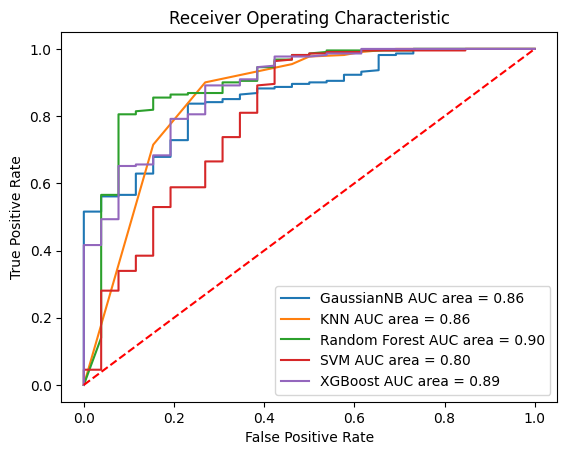

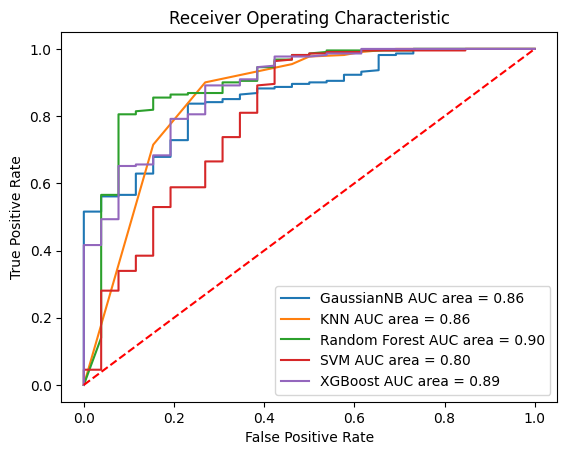

In [16]:
# Plot roc curve for the tuned models
plot_roc_curves_for_models(models_tuned, data_splits['x_test'], data_splits['y_test'], uniprot_id=uniprot_id)

## Deep Learning model: Fully Connected Neural Network - with RayTune

In [17]:
!pip install -q ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 3.1 MB/s eta 0:00:00


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from ray import tune
from ray import train as raytrain
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [19]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
class MyDataset(Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data).float().to(device)
        self.target = torch.from_numpy(target).float().to(device)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [28]:
def string_to_np_array(s: str):
    s = s.strip('[]')
    arr = np.fromstring(s, sep=' ')

    return arr


df = pd.read_csv('data/processed_{}.csv'.format(uniprot_id), index_col=0)
df['fp'] = df['fp'].apply(string_to_np_array)

In [29]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(df['fp'].tolist(), df['active'].tolist(), test_size=0.2,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Creating the datasets
train_dataset = MyDataset(np.array(X_train), np.array(y_train))
val_dataset = MyDataset(np.array(X_val), np.array(y_val))
test_dataset = MyDataset(np.array(X_test), np.array(y_test))

# Creating the dataloaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [30]:
# Define the FCNN
class Net(nn.Module):
    def __init__(self, num_hidden_layers):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        input_units = 167
        for i in range(num_hidden_layers):
            output_units = max(input_units // 2, 1)
            self.layers.append(nn.Linear(input_units, output_units))
            input_units = output_units
        self.fc_out = nn.Linear(input_units, 1)
        self.to(device)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return torch.sigmoid(self.fc_out(x))

In [31]:
# Define a training step
def train(model, optimizer, criterion, data, target):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    target = target.view(-1, 1).float()  # Reshape the target to match the input shape
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    return loss.item()


# Define a validation step
def validate(model, criterion, data, target):
    model.eval()
    with torch.no_grad():
        output = model(data)
        target = target.view(-1, 1)
        loss = criterion(output, target)
        return loss.item()


In [32]:
# Define a function for hyperparameter tuning
def tune_model(config):
    model = Net(num_hidden_layers=config["hidden_layers"])
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.BCELoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    for epoch in range(10):
        loss = 0
        correct = 0
        total = 0
        for batch in train_loader:
            data, target = batch
            loss += train(model, optimizer, criterion, data, target)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        loss /= len(train_loader)
        accuracy = correct / total
        train_losses.append(loss)
        train_accuracies.append(accuracy)

        val_loss = 0
        correct = 0
        total = 0
        for batch in val_loader:
            data, target = batch
            val_loss += validate(model, criterion, data, target)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        val_loss /= len(val_loader)
        accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)

    train_losses = sum(train_losses)/len(train_losses)
    val_losses = sum(val_losses)/len(val_losses)
    train_accuracies = sum(train_accuracies)/len(train_accuracies)
    val_accuracies = sum(val_accuracies)/len(val_accuracies)

    raytrain.report({
        "train_loss": train_losses,
        "train_accuracy": train_accuracies,
        "val_loss": val_losses,
        "val_accuracy": val_accuracies
    })

In [33]:
# Perform hyperparameter tuning
analysis = tune.run(
    tune_model,
    config={
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([8, 16, 32, 64, 128]),
        "hidden_layers": tune.choice([1, 2, 3, 4, 5])
    },
    resources_per_trial={"cpu": 2, "gpu": 0},
    num_samples=10,
    metric="val_loss",
    mode="min"
)

2024-01-08 15:54:12,336	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-08 15:54:12,374	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+-------------------------------------------------------------------+
| Configuration for experiment     tune_model_2024-01-08_15-54-12   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        FIFOScheduler                    |
| Number of trials                 10                               |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/tune_model_2024-01-08_15-54-12

Trial status: 10 PENDING
Current time: 2024-01-08 15:54:12. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+----------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size     hidden_layers |
+----------------------------------------------------------------------------------+
| tune_model_2ac3b_00000   PENDING    0.000751    

In [34]:
# Get the best hyperparameters
best_config = analysis.get_best_config(metric="val_loss", mode="min")

# Train the final model with the best hyperparameters
model = Net(num_hidden_layers=best_config["hidden_layers"])
optimizer = optim.Adam(model.parameters(), lr=best_config["lr"])
criterion = nn.BCELoss()
train_loader = DataLoader(train_dataset, batch_size=best_config["batch_size"], shuffle=True)

for epoch in range(50):
    for batch in train_loader:
        data, target = batch
        train(model, optimizer, criterion, data, target)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        y_true.extend(target.tolist())
        y_pred.extend(output.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred.round())
confusion = confusion_matrix(y_true, y_pred.round())
tn, fp, fn, tp = confusion.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Sensitivity: {sensitivity}')
print(f'AUC: {auc}')

# Save the model
torch.save(model.state_dict(), "models/{}_FCNN_tuned.pt".format(uniprot_id))

Accuracy: 0.8825910931174089
Specificity: 0.32142857142857145
Sensitivity: 0.954337899543379
AUC: 0.8957110241356816


Compare with Machine Learning models above

In [35]:
for ML_model in models_tuned:
  print(ML_model["label"], "\n", ML_model["performance"])

GaussianNB 
 {'Accuracy': 0.1700404858299595, 'Sensitivity': 0.07239819004524888, 'Specificity': 1.0, 'AUC': 0.8604246432300732}
KNN 
 {'Accuracy': 0.9230769230769231, 'Sensitivity': 0.9819004524886877, 'Specificity': 0.4230769230769231, 'AUC': 0.8612948137835016}
Random Forest 
 {'Accuracy': 0.9352226720647774, 'Sensitivity': 0.9909502262443439, 'Specificity': 0.46153846153846156, 'AUC': 0.8993212669683258}
SVM 
 {'Accuracy': 0.9271255060728745, 'Sensitivity': 0.995475113122172, 'Specificity': 0.34615384615384615, 'AUC': 0.7981204316045946}
XGBoost 
 {'Accuracy': 0.9271255060728745, 'Sensitivity': 0.9864253393665159, 'Specificity': 0.4230769230769231, 'AUC': 0.8863557257222415}


# Select the best model for this protein

Based on the ranks of 4 metrics: Accuracy, Sensitivity, Specificity, and AUC of these listed models:  
- GaussianNB  
- KNN  
- Random Forest  
- SVM  
- XGBoost  
- Fully-connected Neural Network  

The best model in this case is:  
**Random Forest**

In [36]:
xgboost_model = [d for d in models_tuned if d.get("label") == "Random Forest"][0]

for key, value in xgboost_model.items():
    print(f"{key}: {value}")

label: Random Forest
model: RandomForestClassifier(min_samples_split=5, n_estimators=300)
performance: {'Accuracy': 0.9352226720647774, 'Sensitivity': 0.9909502262443439, 'Specificity': 0.46153846153846156, 'AUC': 0.8993212669683258}
hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
